In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scipy
import sklearn
from scipy.sparse import csr_matrix

from importlib import reload

sc.settings.verbosity = 3  

# Load data and annotations

In [2]:
def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

In [3]:
"""
DATA
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/merged_anndata/merged_adata.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

"""
ANNOTATIONS
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/annotation/cell_types.csv"
df = load_annotations(fpath)
df = df[df.index.isin(adata.obs_names)]
print(f"{df.shape=}")

adata.obs = pd.concat([adata.obs, df], ignore_index=False, axis=1)
adata

Memory usage: current 8.51 GB, difference +8.51 GB
AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'
df.shape=(171498, 3)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [4]:
adata.obs['dataset'].value_counts()

dataset
weng_young2_all        29289
tabula_sapiens         27313
weng_young1_all_t2     25317
pellin                 19180
weng_young1_all_t1     18499
weng_old2_BMMC_HSPC    17292
weng_old1_BMMC_HSPC    14790
iHSC                    8379
sc_fib                  7736
weng_young2_HSC         3703
Name: count, dtype: int64

In [5]:
adata.obs['standard_cell_type'].value_counts()

standard_cell_type
Fib               34289
HSC               20789
T_cell            19303
LinNeg            13396
B_cell            10734
EryP               9902
MPP                9391
iHSC               8379
MEP                7433
Mono               6988
GMP                4882
NK                 4189
MDP                3989
MKP                3980
CLP                3640
CMP                2804
Dendritic_cell     2694
LMPP                805
PreBNK              554
MLP                 123
Name: count, dtype: int64

# Filtering

In [6]:
cell_types = [
    'Fib',
    'HSC',
    'iHSC',
]

exclude_datasets = [
    'tabula_sapiens',
    'pellin',
    'weng_young2_all',
    'weng_young1_all_t2',
    'weng_young1_all_t1',
    'weng_old2_BMMC_HSPC',
    'weng_old1_BMMC_HSPC',
]

adata = adata[adata.obs['standard_cell_type'].isin(cell_types), :].copy()
adata = adata[~adata.obs['dataset'].isin(exclude_datasets), :].copy()

adata

AnnData object with n_obs × n_vars = 19358 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [7]:
adata.obs['dataset'].value_counts()

dataset
iHSC               8379
sc_fib             7736
weng_young2_HSC    3243
Name: count, dtype: int64

In [8]:
adata.obs['standard_cell_type'].value_counts()

standard_cell_type
iHSC    8379
Fib     7736
HSC     3243
Name: count, dtype: int64

# count filters

In [9]:
def filter_genes_by_group_min_count(adata, group_key, min_count):
    """Filters genes in an AnnData object based on minimum count within all groups.

    Args:
        adata: The AnnData object.
        group_key: The key in `adata.obs` that defines the groups.
        min_count: The minimum count required for a gene within each group.

    Returns:
        AnnData: A new AnnData object with the filtered genes.
    """

    gene_mask = None
    for group_name in adata.obs[group_key].unique():
        group_adata = adata[adata.obs[group_key] == group_name, :]
        gene_counts = group_adata.X.sum(axis=0)
        group_mask = gene_counts >= min_count
        print(f"{group_key}: {group_name} - {group_mask.sum()} genes pass filter")

        if gene_mask is None:
            gene_mask = group_mask
        else:
            gene_mask = gene_mask & group_mask

    filtered_adata = adata[:, gene_mask].copy()
    return filtered_adata


adata = filter_genes_by_group_min_count(
    adata, 
    group_key='dataset',
    min_count=2,
)

adata

dataset: weng_young2_HSC - 12855 genes pass filter
dataset: iHSC - 13724 genes pass filter
dataset: sc_fib - 13247 genes pass filter


AnnData object with n_obs × n_vars = 19358 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

# Load iHSC cluster annotations

In [10]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/analysis.anndata.h5ad"

bdata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

df = bdata.obs.copy()
df.index = df.index + "_iHSC"

ihsc_cluster_map = dict(zip(df.index, df['cluster_str'].values))

df.head()

Memory usage: current 16.39 GB, difference +7.88 GB


,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,EC_score,EB_score,FB_score,HSC_score,MK_score,new_cluster,cluster_str
cell_id,,,,,,,,,,,,,,
AAACCCAAGGTTACCT_iHSC,2352,0.159948,False,2352,6558,0,0.0,-0.117695,1.107518,-0.180062,0.725850,0.264587,0,C1
AAACCCAAGTTGAAGT_iHSC,2324,0.046595,False,2324,5488,0,0.0,-1.490416,-0.212043,0.438982,1.047586,-1.250218,0,C1
AAACCCAAGTTGTCGT_iHSC,1676,0.056037,False,1676,4330,0,0.0,0.662667,-0.494800,-1.764468,-1.091474,0.609457,3,C4
AAACCCACAGAAGCGT_iHSC,1601,0.027108,False,1600,3442,0,0.0,-0.356942,2.013557,-3.152745,0.515070,1.763115,1,C2
AAACCCACAGGAGGTT_iHSC,3604,0.118063,False,3604,14427,0,0.0,0.334405,-0.505029,0.595535,-0.521120,0.271485,0,C1


In [11]:
adata.obs['cell_id'] = adata.obs.index
adata.obs['cluster_str'] = adata.obs['cell_id'].map(ihsc_cluster_map)
adata.obs['cluster_str'].value_counts()

cluster_str
C1    3919
C2    1749
C3    1603
C4     602
C5     447
C6      59
Name: count, dtype: int64

# Filtering our cluster C6

In [12]:
adata = adata[~adata.obs['cluster_str'].isin(['C6']), :].copy()
adata

AnnData object with n_obs × n_vars = 19299 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

# Preprocessing 

In [13]:
# filtration
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

adata.layers["counts"] = csr_matrix(adata.X.astype('float32').copy())

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["norm"] = csr_matrix(adata.X.astype('float32').copy())
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

# combat
sc.pp.combat(
    adata, 
    key='dataset',
    covariates=['total_counts'],
)

adata.X = csr_matrix(adata.X.astype('float32'))

adata.layers["combat"] = adata.X.copy()

# set current layer
adata.X = adata.layers["combat"]

# magic on combat corrected
sce.pp.magic(
    adata,
    name_list='all_genes',
    solver='approximate',
    copy=False,
)

adata.layers["magic"] = csr_matrix(adata.X.astype('float32').copy())

""" SET CURRENT LAYER TO LOG_NORM """
adata.X = adata.layers["combat"] 

adata

filtered out 323 cells that have less than 500 genes expressed
normalizing counts per cell
    finished (0:00:00)
Standardizing Data across genes.

Found 3 batches

Found 1 numerical variables:
	total_counts

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

computing MAGIC
    finished (0:02:31)


AnnData object with n_obs × n_vars = 18976 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'norm', 'log_norm', 'combat', 'magic'

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:19)


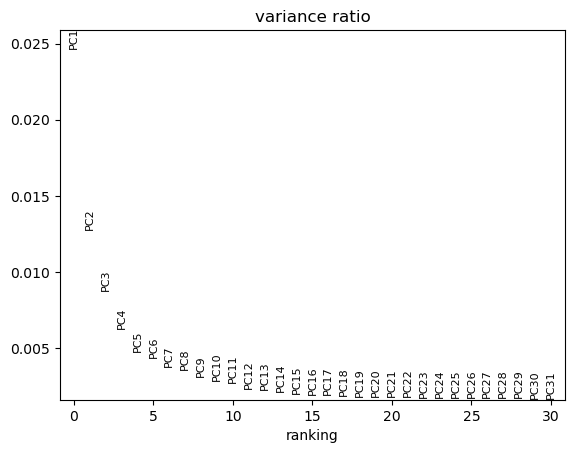

In [14]:
sc.pp.highly_variable_genes(
    adata,
    layer='log_norm',
    batch_key='dataset',
)

sc.tl.pca(
    adata,
    mask_var='highly_variable',
)

sc.pl.pca_variance_ratio(adata)

In [15]:
sc.pp.neighbors(
    adata,
    n_neighbors=55,
)
sc.tl.umap(
    adata,
)
sc.tl.leiden(
    adata, 
    resolution=0.5, 
    key_added='new_cluster',
)
adata

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)
running Leiden clustering


/tmp/ipykernel_3724991/894126761.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 8 clusters and added
    'new_cluster', the cluster labels (adata.obs, categorical) (0:00:05)


AnnData object with n_obs × n_vars = 18976 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'new_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'new_cluster'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm', 'log_norm', 'combat', 'magic'
    obsp: 'distances', 'connectivities'

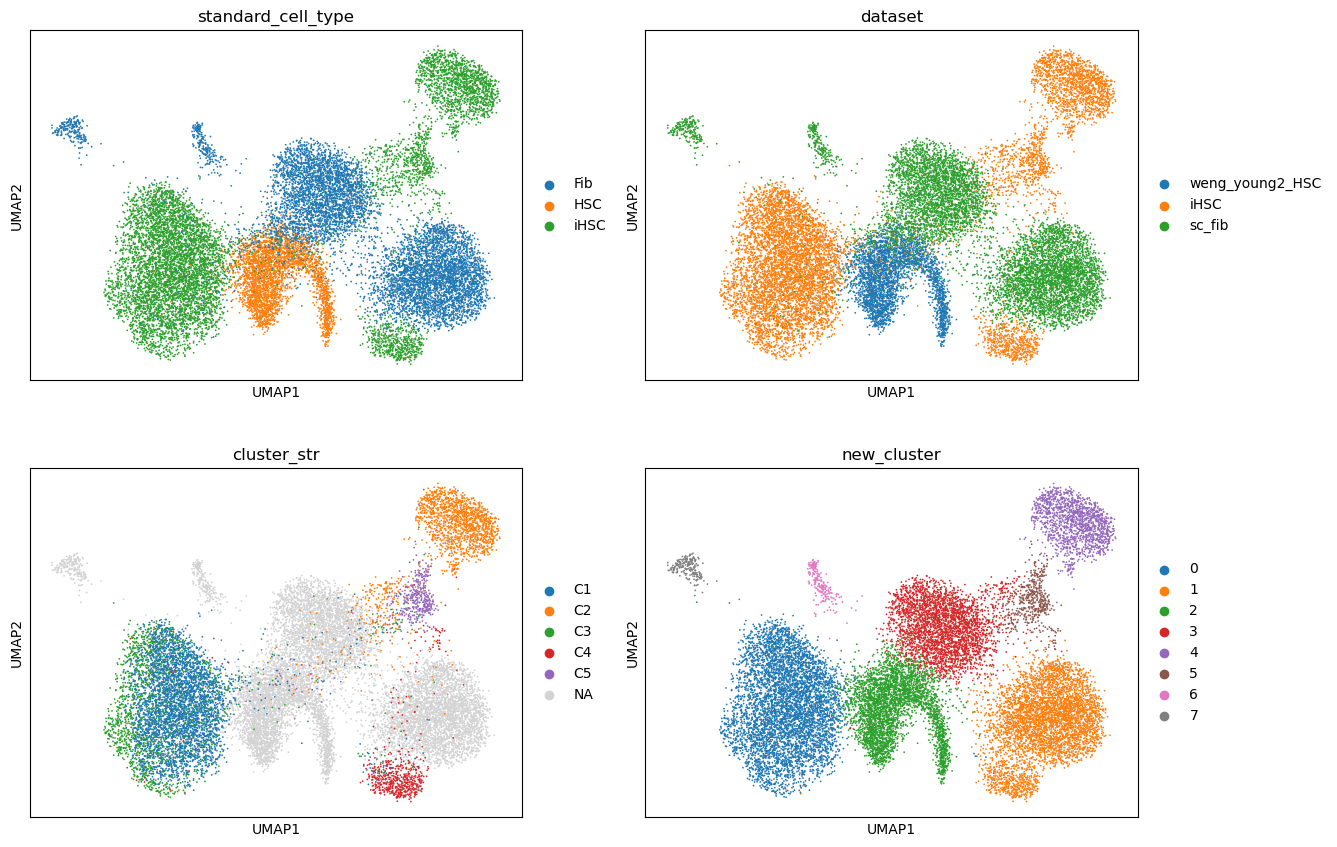

In [16]:
sc.pl.umap(
    adata,
    color=[
        'standard_cell_type',
        'dataset',
        'cluster_str',
        'new_cluster',
    ],
    ncols=2,
)

In [17]:
outpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/native_hsc_sc_fib.h5ad"
adata.write(outpath)
adata

AnnData object with n_obs × n_vars = 18976 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'new_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'new_cluster', 'standard_cell_type_colors', 'dataset_colors', 'cluster_str_colors', 'new_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm', 'log_norm', 'combat', 'magic'
    obsp: 'distances', 'connectivities'